# Why You Need to Stop Using Sigmoids
-----------

In recent years, deep learning and neural networks have been making huge strides in every industry. This AI technology seems to have moved in overnight and allowed us to solve problems which we've been hacking at for years, sometimes even decades.

Although the idea of neural networks have been around since the mid-1900s, they weren't really used outside of the academic world until after 2010, but why? If they're so powerful, then why weren't machine learning practitioners using them in real world applications? It's true that the advancement of computers and the use of GPUs has revolutionized the use of neural networks. A trivial problem which we can now do in less than an hour with modern computing technology used to take days, sometimes weeks in the past, but computing power wasn't the only problem. The other problem we had on our hands was the sigmoid activation and the vanishing gradient problem that it brought with it.

When one decides to embark on the journey of learning deep learning, often the first activation you stumble upon is the sigmoid function – it's simple to explain, has the same backpropagation equations as linear regression and just fits so well in the overall picture. I even used it in my [introductory book to deep learning](https://cutt.ly/cg2nn-intro-medium). The problem with the sigmoid function is that it comes with a caveat – the vanishing gradient problem. This problem was a huge hurdle in what would otherwise be considered a perfect solution. It was such a big hurdle that statisticians ruled out neural networks for decades due to it (well, do to it and the immense computing power neural networks take).

In this article, we're going to take a look at the sigmoid function and try to explain the vanishing gradient with code. We'll also cover how recent practices in deep learning try to overcome this problem.

## Building Our Case (In Code)

As always, the first thing we're going to do is import the libraries required. We'll be using PyTorch, but we won't be using the nn.Module class. Instead, we're going to make our neural networks from scratch, leveraging the autograd capabilities of PyTorch.

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn

Now that we've imported our classes, we're going to write a few functions which we'll be reusing throughout this article.

The first function we'll write out is our weights function. This function will be responsible for creating/initializing the weights for our neural networks. The weights are randomly initialized and are normally distributed. Something to note is that we won't be requiring a bias for this article, hence why I will be leaving it out.

In [2]:
def weights(out, inp):  
  return torch.randn((out, inp), dtype=float, requires_grad=True)

Our second function is the linear function. This is a simple function which does the matrix multiplication between the weights and the features (X).

In [3]:
def linear(weights, X):
  return weights@X

Our third function is the stats function. This returns the mean and standard deviation of any tensor passed to it. Although a simple function, I found that it made my code cleaner.

In [4]:
def stats(layer):
  return torch.mean(layer).item(), torch.std(layer).item()

Init_layers is our fourth function. This accepts a dim and a layers arguments. For the purposes of this article, all of our layers will output the same number of rows and columns, except for our last layer.

In [5]:
def init_layers(dim, layers):
  W = []
  for i in range(layers):
    W.append(weights(dim, dim))
  W.append(weights(1, dim))
  return W

Our last function is the layer_metrics function. This returns a dict which will hold our stats for each connection. This makes looking at the stats of each connection a lot easier.

In [6]:
def layer_metrics(len_W):
  metrics = {}
  for w in range(len(W)):
    metrics[w] = {'mean': [], 'std': []}
  return metrics

Along with those, we're going to be using PyTorch's BCELoss and Sigmoid functions. If you need a refresher and want to know how to write them from scratch, please do refer to [my book](https://cutt.ly/cg2nn-ch2-medium). I cover them in a lot of detail over there.

In [7]:
BCE = nn.BCELoss()
sigmoid = nn.Sigmoid()

Before we get into our neural networks, we're going to need some data. For the purposes of this article, we can get away with something simple. We'll make a features tensor (X) which contains the same number of rows as columns (i.e., 100) and we'll also make a target tensor (y) with half the values being 0 and the other half being 1.

In [8]:
dim = 100
X = torch.randn((dim,dim), dtype=float)
y = torch.cat((torch.zeros(dim//2, dtype=float), torch.ones(dim//2, dtype=float))).reshape(1,-1)

Now that we're finally done with all the boring housekeeping, let's start of by making our first neural network. We're going to make a simple feed forward network of 4 layers, using our helpful functions above. Let's also make a list known as epoch_loss, which will hold the loss (BCE) at each epoch. We'll use it for plotting later on.

In [9]:
epoch_loss = []
layers = 4
W = init_layers(dim, layers)
metrics = layer_metrics(len(W))

Let's train our neural network! We'll train for the 100 epochs at a learning rate of 1e-1, printing the loss at every 10 epochs. We'll also store the stats of every gradient for each epoch.

In [10]:
learning_rate = 1e-1
for epoch in range(100+1):
  y_pred = X
  for j in range(len(W)):
    y_pred = sigmoid(linear(W[j], y_pred))

  loss = BCE(y_pred, y)
  epoch_loss.append(loss)
  if(epoch%10==0):
    print('Epoch {0} loss: {1:0.5}'.format(epoch, loss))
  loss.backward()
  with torch.no_grad():
    for w in range(len(W)):
      m, s = stats(W[w].grad)
      metrics[w]['mean'].append(m)
      metrics[w]['std'].append(s)
      W[w] -= learning_rate * W[w].grad

  for w in W:
    w.grad.zero_()

Epoch 0 loss: 4.2891
Epoch 10 loss: 0.73831
Epoch 20 loss: 0.51932
Epoch 30 loss: 0.38241
Epoch 40 loss: 0.29454
Epoch 50 loss: 0.23625
Epoch 60 loss: 0.19624
Epoch 70 loss: 0.1676
Epoch 80 loss: 0.14624
Epoch 90 loss: 0.12972
Epoch 100 loss: 0.11656


Awesome, we trained our neural network. We don't really care to fit a good model, hence why we're training for such a small number of epochs. We're more interested in dissecting our model to understand how the sigmoid works. Let's take a look at our stats for the gradients.

Because we're going to be plotting a lot in this article, I thought it would be best to write a function for it. It's a simple function which plots the loss, and then goes through our model and plots stats for our connections. It plots at the 0th connection, and then at every ¼ way through our model (in our first model's case, this happens to be every connection).

In [11]:
def plot_metrics(epoch_loss, metrics):
  skip = len(metrics)//4 ##len(metrics) must be >= 4
  f, axarr = plt.subplots(6, sharex=True, figsize=(5, 15))
  axarr[0].plot(epoch_loss)
  axarr[0].set_title('Loss')
  for i in range(5):
    axarr[i+1].plot(metrics[i*skip]['mean'], label='mean')
    axarr[i+1].plot(metrics[i*skip]['std'], label='std')
    axarr[i+1].legend(loc="upper right")
    axarr[i+1].set_title('Connection ' + str(i*skip))

  f.subplots_adjust(hspace=0.3)
  plt.show()

Let's take a look at our model's stats.

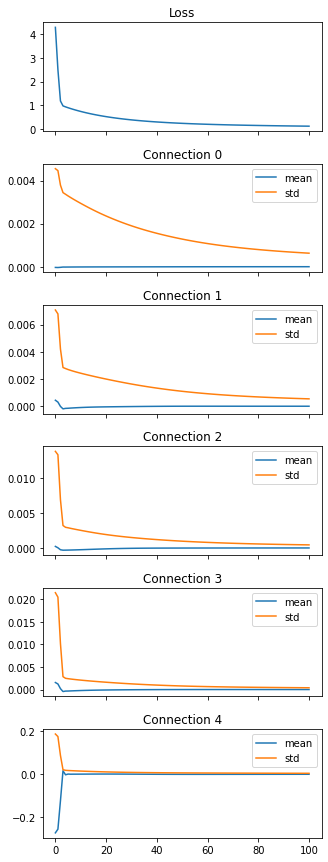

In [12]:
plot_metrics(epoch_loss, metrics)

What we're seeing above are our loss and the stats (i.e., mean and standard deviation) for our gradients at each connection for each epoch. What do I mean by gradients? If you need a refresher, you can always refer back to [my introductory book on neural networks](https://cutt.ly/cg2nn-ch1-medium), where I explain them in further detail, but essentially, the gradients are the values which are multiplied by the learning rate and then used to subtract from the weights which make up the given connection.

Something you'll realize is that as our loss goes down, our gradients also shrink. That's something to keep in mind while we move on to our next model

## Plotting the Vanishing Gradient

Let's train another model for the same number of epochs and learning rate, but this time, our model will consist of 100 layers instead of just 4.

In [13]:
epoch_loss = []
layers = 100
W = init_layers(dim, layers)
metrics = layer_metrics(len(W))

for epoch in range(100+1):
  y_pred = X
  for j in range(len(W)):
    y_pred = sigmoid(linear(W[j], y_pred))

  loss = BCE(y_pred, y)
  epoch_loss.append(loss)
  if(epoch%10==0):
    print('Epoch {0} loss: {1:0.5}'.format(epoch, loss))
  loss.backward()
  with torch.no_grad():
    for w in range(len(W)):
      m, s = stats(W[w].grad)
      metrics[w]['mean'].append(m)
      metrics[w]['std'].append(s)
      W[w] -= learning_rate * W[w].grad

  for w in W:
    w.grad.zero_()

Epoch 0 loss: 1.2008
Epoch 10 loss: 0.71869
Epoch 20 loss: 0.69336
Epoch 30 loss: 0.69315
Epoch 40 loss: 0.69315
Epoch 50 loss: 0.69315
Epoch 60 loss: 0.69315
Epoch 70 loss: 0.69315
Epoch 80 loss: 0.69315
Epoch 90 loss: 0.69315
Epoch 100 loss: 0.69315


Let's have a look at our stats for our 100 layer model.

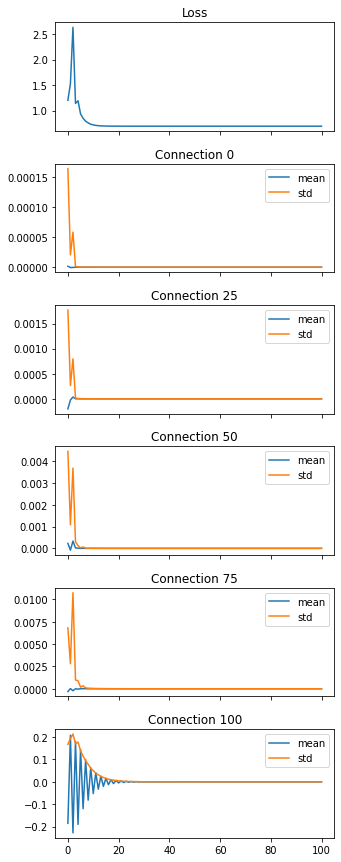

In [14]:
plot_metrics(epoch_loss, metrics)

Here is where we see the vanishing gradient problem in action. We were somewhat seeing it in the previous model, but not to the extent as we see in this model.

The first thing you'll probably have noticed is that although our model is more complex, our loss is significantly worse than our previous model and that the loss actually seems to just have stopped improving after about 30 epochs. 

The second thing you'll see is that if you examine the Connection 100 plot, you'll notice that after oscillating a bit, our mean and standard deviation essentially hover around zero.

The last and probably most important part I want us to examine are the scales of our plots. You'll see that the scales get smaller as we move down our connections – the 100th connection has a larger scale than our 75th connection, our 75th connection has a larger scale than our 50th connection, and so on. This is the manifestation of the vanishing gradient problem.

Our initial connection gradients are very small. In fact, they're so small that when we take those numbers and multiply them by our learning rate (i.e., a decimal value which lies between 0 and 1), they actually shrink further. We end up subtracting such a small number from our weights at those initial layers that it's almost equivalent to subtracting nothing at all. The other realization you might have had is that the mean and standard deviation of our gradients in our earlier connections approach zero much faster than in our later connections.

What we've just shown is that the sigmoid performs extremely poorly on deep neural networks, causing the gradients to almost completely vanish.

So why does that happen? To understand this, let's take a look at diagram below.


![sigmoid%20with%20derivative.png](images/sigmoid%20with%20derivative.png?raw=true)

This diagram explains the derivative value of the sigmoid activation function at different points on the graph (if you need a refresher on how the derivatives are required for the backpropagation, please refer to my introductory book on neural networks). What we're seeing from the diagram above is that the values of the derivatives are between 0 and 0.25. That right there is the fundamental problem with the sigmoid activation function. Backpropagation is made up of the chain rule, and the chain rule is essentially made up of multiplying derivatives together. In essence, what we're doing is multiplying a decimal value between 0 and 0.25 with another decimal value between 0 and 0.25, and in our model above, we do that 100 times over. Multiplying anything with a decimal value between 0 and 1 decays it. Doing that over and over again decays it exponentially fast.

That was a lengthy explanation, but I hope it wasn't too confusing. It took me a while to understand, so if you're having a hard time, I don't blame you. Maybe play with the code and read it over a few times to really allow it to sink in.

## ReLu

Realizing the problems with the sigmoid function, deep learning researchers first applied the ReLu (rectified linear unit) in 2011. Currently, the ReLu (along with its different flavours) are the most used activation functions in practical deep learning.

<img src="images/relu%20with%20derivative.png?raw=true"  width="500" height="500">

If we look at the diagram above, we'll see that the derivatives for ReLu avoid decimal values between 0 and 1, rather, they have only 2 values – 0 or 1 (which presents another problem, but that discussion is for another time).

Although the term sounds fancy, don't let it scare you. The equation is simple. All we need to do is turn values less than 0 into 0 and leave the rest a they are. In code, it looks like the following.

In [15]:
def ourRelu(linear):
  return linear.clamp(min=0)

We're going to use PyTorch's built-in ReLu function for the sake of consistency, but you could easily replace it with the ourRelu function we made above and it should give you the same results.

In [16]:
relu = nn.ReLU()

Now that we have our new and improved activation function, let's tweak our 100 layer model from above to use ReLu instead of sigmoid and retrain.

In [17]:
epoch_loss = []
W = init_layers(dim, layers)
metrics = layer_metrics(len(W))

for epoch in range(100+1):
  y_pred = X
  for j in range(len(W)):
    y_pred = relu(linear(W[j], y_pred))

  loss = BCE(sigmoid(y_pred), y)
  epoch_loss.append(loss)
  if(epoch%10==0):
    print('Epoch {0} loss: {1:0.5}'.format(epoch, loss))
  loss.backward()
  with torch.no_grad():
    for w in range(len(W)):
      m, s = stats(W[w].grad)
      metrics[w]['mean'].append(m)
      metrics[w]['std'].append(s)
      W[w] -= learning_rate * W[w].grad

  for w in W:
    w.grad.zero_()

Epoch 0 loss: 0.69315
Epoch 10 loss: 0.69315
Epoch 20 loss: 0.69315
Epoch 30 loss: 0.69315
Epoch 40 loss: 0.69315
Epoch 50 loss: 0.69315
Epoch 60 loss: 0.69315
Epoch 70 loss: 0.69315
Epoch 80 loss: 0.69315
Epoch 90 loss: 0.69315
Epoch 100 loss: 0.69315


Before we explain the output, let's take a quick look at our code. Because we're using the BCELoss function, it expects our predicted values to be between 0 and 1, hence why our final prediction is passed through a sigmoid function before being passed into the BCELoss function.

Continuing on with our output, you probably noticed that our model didn't perform well. In fact, it didn't perform at all. It seems that the ReLu function failed us.

Let's look at the gradients and see if we can deduce something from them.

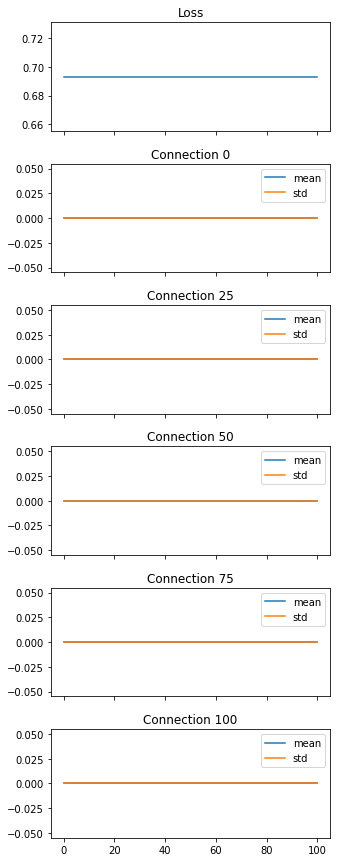

In [18]:
plot_metrics(epoch_loss, metrics)

Looks like our gradients are just flat at 0. Why? Doesn't that mean the sigmoid function's better? Actually, the sigmoid function might just be the reason we're getting these weird results with the ReLu.

Let's take a look at how the predicted values look before throwing them into the sigmoid function.

In [19]:
y_pred

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=torch.float64, grad_fn=<ReluBackward0>)

That's interesting. We're seeing are a bunch of 0s (depending on when you run it, you might see 0s, very large numbers or a mixture of both). It's a little unfortunate, because, if you remember the sigmoid diagram from above, the sigmoid turns the value 0 into 0.5 and any value greater than about 5 into a 1. The problem is that those are the only 2 values we can receive – 0 and values far greater than 5.

Just to prove this, let's look what happens when we pass it into the sigmoid.

In [20]:
sigmoid(y_pred)

tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000]], dtype=torch.float64, grad_fn=<SigmoidBackward>)

As expected, we have 0.5 all around (again, depending on when you run it, you might see 0.5, 1 or a mixture of both). Turns out the sigmoid function seems to be the culprit. Since this is what we throw into our loss function, it's not very helpful for our model to learn anything.

## Kaiming Initialization
To fix this problem, we're going to try and tweak our weights initializations. It's going to be a little addition to our already existing equation. This tweak was introduced in 2015 and is known as the [Kaiming initialization (named after Kaiming He)](https://arxiv.org/pdf/1502.01852.pdf).

The tweak is quite simple. We're going to multiply our weights by 2/n (the sigmoid version for the Kaiming initailization is 1/n), where n is the input dimension for our connection.

Let's look at the code for it, in case the above was a little confusing.

In [21]:
import math
def weights(out, inp):  
  w = torch.randn((out, inp), dtype=float, requires_grad=True)*math.sqrt(2/inp)
  return w.detach().requires_grad_(True)

The function is very straightforward when you take a look at it. It's almost the same as our weights function above, minus the multiplication by a fraction. Also, sorry for the "detach().requires_grad_(True)" bit, but I'm not aware of another way to easily multiply a tensor with a fraction while keeping its gradient.

Finally, let's train our model with the Kaiming initalization and ReLu.

Note: sometimes this part is a little finicky. If you're seeing no improvement in your loss, just re-run this a few times until it does work.

In [22]:
learning_rate = 1e-4

epoch_loss = []
W = init_layers(dim, layers)
metrics = layer_metrics(len(W))
  
for epoch in range(100+1):
  y_pred = X
  for j in range(len(W)):
    y_pred = relu(linear(W[j], y_pred))

  loss = BCE(sigmoid(y_pred), y)
  epoch_loss.append(loss)
  if(epoch%10==0):
    print('Epoch {0} loss: {1:0.5}'.format(epoch, loss))
  loss.backward()
  with torch.no_grad():
    for w in range(len(W)):
      m, s = stats(W[w].grad)
      metrics[w]['mean'].append(m)
      metrics[w]['std'].append(s)
      W[w] -= learning_rate * W[w].grad

  for w in W:
    w.grad.zero_()

Epoch 0 loss: 0.69286
Epoch 10 loss: 0.69261
Epoch 20 loss: 0.69248
Epoch 30 loss: 0.69234
Epoch 40 loss: 0.69225
Epoch 50 loss: 0.69219
Epoch 60 loss: 0.69213
Epoch 70 loss: 0.69208
Epoch 80 loss: 0.69203
Epoch 90 loss: 0.69197
Epoch 100 loss: 0.69192


Awesome! Looks like our model is learning! I had to decrease the learning rate to 1e-4, but it works.

Let's plot our gradients to see how they look.

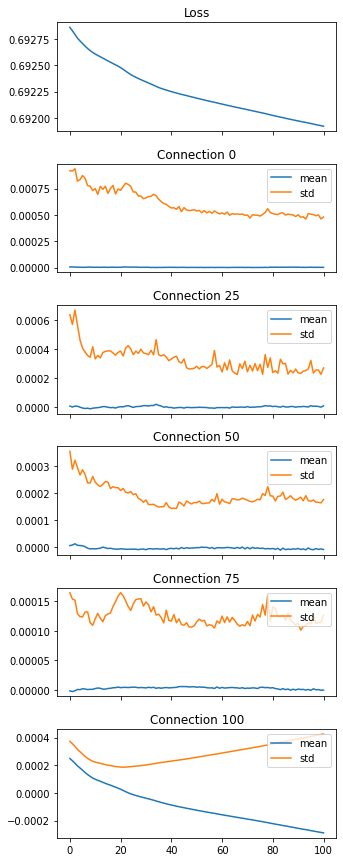

In [23]:
plot_metrics(epoch_loss, metrics)

This is exactly what we wanted to see. As we take a look at our the plots for our initial connections, we can see that the scale remains more or less the same throughout the connections, proving that they gradients aren't vanishing. Another plus is that our gradients are no longer taking a nose dive to 0 as they were when we used the sigmoid function.

## PyTorch's Linear Function
Throughout this lesson, you were probably wondering why we didn't just use PyTorch's built-in Linear function. The reason for that is because PyTorch's Linear function actually implements Kaiming initialization for us (Running the code cell below in Google colab will cause the source code to pop-up on the right. Scroll through it to the Kaiming portion in the function reset_parameters.)

In [24]:
nn.Linear??

<img src="images/pytorch%20linear%20kaiming.PNG?raw=true"  width="500" height="500">

Hope you enjoyed the article. We're covered explaining the vanishing gradient problem along with the reason as to why we use ReLu and how to initialize the weights with the Kaiming initialization, but I thought it would be unfair to end this article without mentioning that there are several other initalization methods. The good news is that they're very similar to the Kaiming initialization method. A very popular alternative is the [Xavier initialzation (named after Xavier Glorot)](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf).

With that, I end this article. Hope it helped solidify a fundamental, but often overlooked aspect of deep learning.